In [1]:
import xcast as xc 
import matplotlib.pyplot 
import pandas as pd 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature

In [2]:
from bootstrap import * 
extent = dict(north=38, south=5, east=100, west=65)
x23 = download_ecmwf(extent, target=(7, 21), training_season=(pd.Timestamp(2020, 5, 25), pd.Timestamp(2020, 9, 7)) )

Email: kjhall@iri.columbia.edu
Password: ········
URL: ParseResult(scheme='http', netloc='iridl.ldeo.columbia.edu', path='/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/S/%2825%20May%202020%29/%287%20Sep%202020%29/RANGEEDGES/L/7/21/VALUES/%5BL%5D/differences/X/65/100/RANGEEDGES/Y/5/38/RANGEEDGES/hdate/%282000%29/VALUES/data.nc', params='', query='', fragment='')
AUTHORIZED: http://iridl.ldeo.columbia.edu/auth/login?ver=1&redirect=%2FSOURCES%2F.ECMWF%2F.S2S%2F.ECMF%2F.reforecast%2F.perturbed%2F.sfc_precip%2F.tp%2FS%2F%252825%2520May%25202020%2529%2F%25287%2520Sep%25202020%2529%2FRANGEEDGES%2FL%2F7%2F21%2FVALUES%2F%255BL%255D%2Fdifferences%2FX%2F65%2F100%2FRANGEEDGES%2FY%2F5%2F38%2FRANGEEDGES%2Fhdate%2F%25282000%2529%2FVALUES%2Fdata.nc&realm=iri.columbia.edu%2Fterms%2Fs2s%2F1
URL: ParseResult(scheme='http', netloc='iridl.ldeo.columbia.edu', path='/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/S/%2825%20May%202020%29/%287%20Sep%202020%29/RANGEEDGES/L/

URL: ParseResult(scheme='http', netloc='iridl.ldeo.columbia.edu', path='/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/S/%2825%20May%202020%29/%287%20Sep%202020%29/RANGEEDGES/L/7/21/VALUES/%5BL%5D/differences/X/65/100/RANGEEDGES/Y/5/38/RANGEEDGES/hdate/%282011%29/VALUES/data.nc', params='', query='', fragment='')
AUTHORIZED: http://iridl.ldeo.columbia.edu/auth/login?ver=1&redirect=%2FSOURCES%2F.ECMWF%2F.S2S%2F.ECMF%2F.reforecast%2F.perturbed%2F.sfc_precip%2F.tp%2FS%2F%252825%2520May%25202020%2529%2F%25287%2520Sep%25202020%2529%2FRANGEEDGES%2FL%2F7%2F21%2FVALUES%2F%255BL%255D%2Fdifferences%2FX%2F65%2F100%2FRANGEEDGES%2FY%2F5%2F38%2FRANGEEDGES%2Fhdate%2F%25282011%2529%2FVALUES%2Fdata.nc&realm=iri.columbia.edu%2Fterms%2Fs2s%2F1
URL: ParseResult(scheme='http', netloc='iridl.ldeo.columbia.edu', path='/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/S/%2825%20May%202020%29/%287%20Sep%202020%29/RANGEEDGES/L/7/21/VALUES/%5BL%5D/differences/X/65/100/RANGEEDGE

<xarray.Dataset>
Dimensions:  (M: 10, S: 31, L: 1, X: 25, Y: 23, hdate: 1)
Coordinates:
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * S        (S) float32 2.206e+04 2.206e+04 2.207e+04 ... 2.216e+04 2.216e+04
  * L        (L) float32 14.0
  * X        (X) float32 64.5 66.0 67.5 69.0 70.5 ... 94.5 96.0 97.5 99.0 100.5
  * Y        (Y) float32 4.5 6.0 7.5 9.0 10.5 12.0 ... 31.5 33.0 34.5 36.0 37.5
  * hdate    (hdate) float32 642.0
Data variables:
    tp       (hdate, S, L, M, Y, X) float32 ...
<xarray.Dataset>
Dimensions:  (M: 10, S: 31, L: 1, X: 25, Y: 23, hdate: 1)
Coordinates:
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * S        (S) float32 2.206e+04 2.206e+04 2.207e+04 ... 2.216e+04 2.216e+04
  * L        (L) float32 14.0
  * X        (X) float32 64.5 66.0 67.5 69.0 70.5 ... 94.5 96.0 97.5 99.0 100.5
  * Y        (Y) float32 4.5 6.0 7.5 9.0 10.5 12.0 ... 31.5 33.0 34.5 36.0 37.5
  * hdate    (hdate) float32 654.0
Data variables:
    

# Parameters

In [3]:
ND=10
hidden_layer_size=50
activation = 'relu'
preprocessing = 'minmax'
target = 'WK23' # WK23 or WK34

# Load Data

In [6]:
# open data files
#x23 = xr.open_dataset('ECMWF_{}_JJAS.nc'.format(target)).tp
bd23 = xr.open_dataset('ENACTS-BD-{}.nc'.format(target)).rfe_merged.sel(T=x23.coords['S'].values)
imd23 = xr.open_dataset('IMD-DAILY-{}.nc'.format(target)).rf.sel(time=x23.coords['S'].values)
x23 = x23.mean('L').tp


# regrid predictors onto predictands 
bd_x23 = xc.regrid(x23, bd23.coords['X'].values, bd23.coords['Y'].values)
imd_x23 = xc.regrid(x23, imd23.coords['lon'].values, imd23.coords['lat'].values)



# Calculate Rolling Tercile Categories

In [7]:
# one-hot encode predictands for skill evaluation 
ohc = xc.RankedTerciles()
ohc.fit(imd23)
imd_ohc = ohc.transform(imd23)

ohc = xc.RankedTerciles()
ohc.fit(bd23)
bd_ohc = ohc.transform(bd23)

# Leave-One-Year-Out Cross Validation

In [8]:
imd_wk23_hcsts = []
bd_wk23_hcsts = []
start, i = pd.Timestamp.now(), 1
for year in range(2000, 2020):
    if year == 2000:
        bd_xtrain23 = bd_x23.sel(S=slice(pd.Timestamp(2000, 12, 31), None))
        bd_xtest23 = bd_x23.sel(S=slice(None, pd.Timestamp(2000, 12, 31)) )
        
        imd_xtrain23 = imd_x23.sel(S=slice(pd.Timestamp(2000, 12, 31), None))
        imd_xtest23 = imd_x23.sel(S=slice(None, pd.Timestamp(2000, 12, 31)) )
        
        imdtrain23 = imd23.sel(time=slice(pd.Timestamp(2000, 12, 31), None))
        imdtest23 = imd23.sel(time=slice(None,  pd.Timestamp(2000, 12, 31)))
        bdtrain23 = bd23.sel(T=slice( pd.Timestamp(2000, 12, 31), None))
        bdtest23 = bd23.sel(T=slice( None, pd.Timestamp(2000, 12, 31)))
    elif year == 2019: 
        bd_xtrain23 = bd_x23.sel(S=slice( None, pd.Timestamp(2018, 12, 31)))
        bd_xtest23 = bd_x23.sel(S=slice(pd.Timestamp(2018, 12, 31), None) )
        
        imd_xtrain23 = imd_x23.sel(S=slice( None, pd.Timestamp(2018, 12, 31)))
        imd_xtest23 = imd_x23.sel(S=slice(pd.Timestamp(2018, 12, 31), None) )
        
        imdtrain23 = imd23.sel(time=slice(None, pd.Timestamp(2018, 12, 31)))
        imdtest23 = imd23.sel(time=slice(pd.Timestamp(2018, 12, 31), None))
        bdtrain23 = bd23.sel(T=slice(None, pd.Timestamp(2018, 12, 31)))
        bdtest23 = bd23.sel(T=slice(pd.Timestamp(2018, 12, 31), None)) 
    else: 
        bd_xtrain23_low = bd_x23.sel(S=slice(None, pd.Timestamp(year-1, 12, 31)))
        bd_xtrain23_high = bd_x23.sel(S=slice( pd.Timestamp(year, 12, 31), None) )
        bd_xtrain23 = xr.concat([bd_xtrain23_low, bd_xtrain23_high], 'S')
        bd_xtest23 = bd_x23.sel(S=slice(pd.Timestamp(year-1, 12, 31), pd.Timestamp(year, 12, 31) ) )
        
        imd_xtrain23_low = imd_x23.sel(S=slice(None, pd.Timestamp(year-1, 12, 31)))
        imd_xtrain23_high = imd_x23.sel(S=slice( pd.Timestamp(year, 12, 31), None) )
        imd_xtrain23 = xr.concat([imd_xtrain23_low, imd_xtrain23_high], 'S')
        imd_xtest23 = imd_x23.sel(S=slice(pd.Timestamp(year-1, 12, 31), pd.Timestamp(year, 12, 31) ) )
        
        imdtrain23_low = imd23.sel(time=slice(None, pd.Timestamp(year-1, 12, 31)))
        imdtrain23_high = imd23.sel(time=slice(pd.Timestamp(year, 12, 31), None))
        imdtrain23 = xr.concat([imdtrain23_low, imdtrain23_high], 'time')
        imdtest23 = imd23.sel(time=slice(pd.Timestamp(year-1, 12, 31), pd.Timestamp(year, 12, 31) ) )
        
        bdtrain23_low = bd23.sel(T=slice(None, pd.Timestamp(year-1, 12, 31)))
        bdtrain23_high = bd23.sel(T=slice(pd.Timestamp(year, 12, 31), None))
        bdtrain23 = xr.concat([bdtrain23_low, bdtrain23_high], 'T')
        bdtest23 = bd23.sel(T=slice(pd.Timestamp(year-1, 12, 31), pd.Timestamp(year, 12, 31) ) )
    
    imdt_ohc = xc.RankedTerciles()
    imdt_ohc.fit(imdtrain23)
    imd_ohc_y_train = imdt_ohc.transform(imdtrain23)
    

    imdpoelm = xc.cPOELM(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
    imdpoelm.fit(imd_xtrain23, imd_ohc_y_train)
    imdpoelm_preds = imdpoelm.predict(imd_xtest23)
    imd_wk23_hcsts.append(imdpoelm_preds)
    
    bdt_ohc = xc.RankedTerciles()
    bdt_ohc.fit(bdtrain23)
    bd_ohc_y_train = bdt_ohc.transform(bdtrain23)
    
    bdpoelm = xc.cPOELM(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
    bdpoelm.fit(bd_xtrain23, bd_ohc_y_train)
    bdpoelm_preds = bdpoelm.predict(bd_xtest23)
    bd_wk23_hcsts.append(bdpoelm_preds)
    
    print('Fiting Window {}/20 - {}'.format(i, pd.Timestamp.now() - start), end='\r')
    i+= 1
bd_wk23 = xr.concat(bd_wk23_hcsts, 'S')
imd_wk23 = xr.concat(imd_wk23_hcsts, 'S')


# Calculate & Show Skill 

In [9]:
start = pd.Timestamp.now()
bd = bd_wk23.mean('ND')
bdgroc = xc.GeneralizedROC(bd, bd_ohc)
bdpoelm_rps = xc.RankProbabilityScore(bd, bd_ohc)
bdclimatological_odds = xr.ones_like(bd) * 0.33 
bdclimo_rps = xc.RankProbabilityScore(bdclimatological_odds, bd_ohc)
bdrpss = 1 - ( bdpoelm_rps / bdclimo_rps)
print(pd.Timestamp.now() - start)

0 days 00:05:11.995250


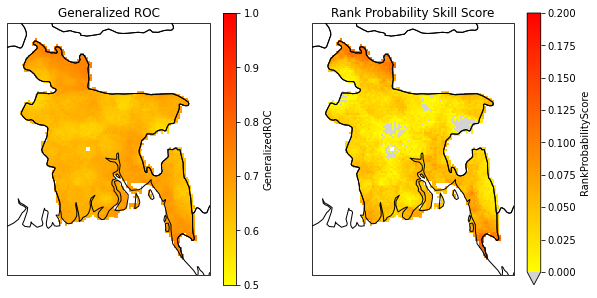

In [10]:
cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
bdgroc.plot(ax=ax[0], vmin=0.5, vmax=1, cmap=cmap)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax[0].add_feature(states_provinces)
ax[0].set_title('Generalized ROC')

bdrpss.plot(ax=ax[1], vmin=0, vmax=0.2, cmap=cmap)
ax[1].add_feature(states_provinces)
ax[1].set_title('Rank Probability Skill Score')
plt.show()

In [11]:
start = pd.Timestamp.now()
imd = imd_wk23.mean('ND')
imdgroc = xc.GeneralizedROC(imd, imd_ohc)
imdpoelm_rps = xc.RankProbabilityScore(imd, imd_ohc)
imdclimatological_odds = xr.ones_like(imd) * 0.33 
imdclimo_rps = xc.RankProbabilityScore(imdclimatological_odds, imd_ohc)
imdrpss = 1 - ( imdpoelm_rps / imdclimo_rps)
print(pd.Timestamp.now() - start)

0 days 00:06:19.940791


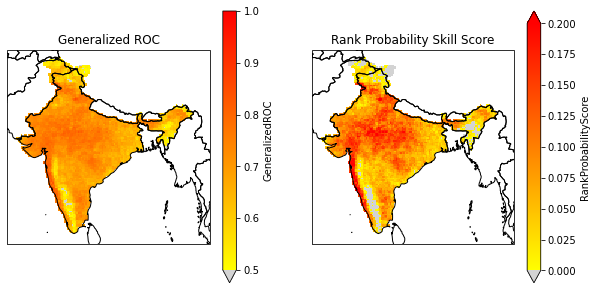

In [15]:
cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
imdgroc.plot(ax=ax[0], vmin=0.5, vmax=1, cmap=cmap)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax[0].add_feature(states_provinces)
ax[0].set_title('Generalized ROC')

imdrpss.plot(ax=ax[1], vmin=0, vmax=0.2, cmap=cmap)
ax[1].add_feature(states_provinces)
ax[1].set_title('Rank Probability Skill Score')
plt.show()

In [17]:
bd_wk23.to_netcdf("ECMWF_MULTIMEMBER_POELM_L1YO_HCST_WK{}_BD.nc".format(target))
imd_wk23.to_netcdf("ECMWF_MULTIMEMBER_POELM_L1YO_HCST_WK{}_IMD.nc".format(target))
imdrpss.to_netcdf('ECMWF_MULTIMEMBER_POELM_L1YO_RPSS_WK{}_IMD.nc'.format(target))
imdgroc.to_netcdf('ECMWF_MULTIMEMBER_POELM_L1YO_GROC_WK{}_IMD.nc'.format(target))
bdrpss.to_netcdf('ECMWF_MULTIMEMBER_POELM_L1YO_RPSS_WK{}_BD.nc'.format(target))
bdgroc.to_netcdf('ECMWF_MULTIMEMBER_POELM_L1YO_GROC_WK{}_BD.nc'.format(target))

In [18]:
x23.to_netcdf('ECMWF_{}_JJAS.nc'.format(target))